In [7]:
import pickle 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.optimize import minimize
from IPython.display import display, Latex


In [8]:
d2metals = {
    '3': ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu'],
    '4': ['Nb', 'Mo', ],
    '5': ['W', ]
}

# for plotting
ele2col = {
    "Ti": "#808080",
    "V": "#ffcccb",
    "Cr": "k",
    "Mn": "#9b870c",
    "Fe": "r",
    "Co": "b",
    "Cu": "#FFFF00",
    "Nb": "cyan",
    "Mo": "#FFA500",
    "Sn": "k",
    "W": "fuchsia",
    "Ir": "b",
    "Ni": "#66FF00",
}

In [9]:
def plot_parabola(parabola):
    x = np.linspace(0, 4, 10)
    y = parabola[0]*x**2+parabola[1]*x
    plt.plot(x, y)
    
def formation_energy_mixing(ele1, ele2, concentrations, plotting=False):
    ox_quadratic_1 = mp_quadratic_equations_ox[ele1]
    ox_quadratic_2 = mp_quadratic_equations_ox[ele2]
    red_quadratic_1 = mp_quadratic_equations_red[ele2]
    red_quadratic_2 = mp_quadratic_equations_red[ele1]

    predicted_forms_1 = []
    predicted_forms_2 = []
    predicted_ox_change_1 = []
    predicted_ox_change_2 = []
    minima = []
    x_tots = []
    for conc in concentrations:
        
        o_1a, o_2a = ox_quadratic_1
        r_1a, r_2a = red_quadratic_1

        o_1b, o_2b = ox_quadratic_2
        r_1b, r_2b = red_quadratic_2
        if plotting:
            #print('checking {}'.format(conc))
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a, True), bounds=[(0, 10)])
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b, True), bounds=[(0, 10)])
            
        else:
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a),  bounds=[(0, 10)])
            # Note, the definition of concentration is different  between 1/2,
            # since it relates to the concentration of the element that is 
            # oxidisint or reducing.
            #handle this when plotting by flipping the x-axis horizontally
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b),  bounds=[(0, 10)])
        
        x_space = np.linspace(0, 3, 50)
        predicted_ox_change_1.append(result_1.x[0])
        # this can give problems depending on scipy version, might have to use result_1.fun
        predicted_forms_1.append(result_1.fun)
        predicted_ox_change_2.append(result_2.x[0])
        predicted_forms_2.append(result_2.fun)#result_2.fun[0] + diff*(1-conc))
        
        if plotting:
            mixed_1 = o_1a*(x_space**2)*(1-conc)**2+o_2a*x_space*(1-conc)+r_1a*(x_space**2)*conc**2+r_2a*x_space*conc
            ox1 = o_1a*x_space**2+o_2a*x_space
            red1 = r_1a*x_space**2+r_2a*x_space
            mixed_2 = o_1b*(x_space**2)*(conc)**2+o_2b*x_space*(conc)+(r_1b*((1-conc)*x_space)**2+r_2b*(1-conc)*x_space)
            ox2 = o_1b*x_space**2+o_2b*x_space
            red2 = r_1b*x_space**2+r_2b*x_space

            if min(mixed_1)<min(mixed_2):
                minima.append(min(mixed_1))
                x_tots.append(result_1.x[0])
                if conc not in [0, 1]:
                    plt.plot(x_space, mixed_1, label='mixed_{}{:.1f}{}{:.1f}'.format(ele1, 1-conc, ele2, conc), color='gray')
                    plt.plot(result_1.x[0], min(mixed_2), 'bo')
                if conc==0:
                    plt.plot(x_space, ox1, label=ele1+"_ox", color=ele2col[ele1[:-1]])
                    plt.plot(x_space, red1, label=ele2+"_red", color=ele2col[ele2[:-1]])
                if conc==1:
                    plt.legend(fontsize=13)
                    plt.xticks(fontsize=13)
                    plt.yticks(fontsize=13)
                    plt.savefig("{}_{}_mixing.pdf".format(ele1, ele2))
                    plt.show()
            else:
                minima.append(min(mixed_2))
                x_tots.append(result_2.x[0])
                if conc not in [0, 1]:
                    plt.plot(x_space, mixed_2, label='mixed_{}{:.2f}{}{:.2f}'.format(ele1, 1-conc, ele2, conc), )#color='gray')
                    plt.plot(result_2.x[0], min(mixed_2), 'bo')
                if conc==0:
                    plt.plot(x_space, ox2, label=ele2+"_ox", color=ele2col[ele2[:-1]])
                    plt.plot(x_space, red2, label=ele1+"_red", color=ele2col[ele1[:-1]])
                if conc==1:
                    plt.legend(fontsize=13)
                    plt.xticks(fontsize=13)
                    plt.yticks(fontsize=13)
                    plt.legend()
                    plt.savefig("{}_{}_mixing.pdf".format(ele1, ele2))
                    plt.show()
    
    if plotting:
        print("X_tots")
        for x in x_tots:
            print("{:.2f}".format(x), end=", ")
        print("\nΔ Cs")
        for x in minima:
            print("{:.2f}".format(x), end=", ")
        plt.plot(concentrations, minima)
        plt.plot([0, 1], [minima[0], minima[-1]], 'k--')
        plt.legend(fontsize=13)
        plt.xticks([0, 0.25, 0.5, 0.75, 1], fontsize=13)
        plt.yticks(fontsize=13)
        
        plt.savefig("deltaC_1c.pdf")
        plt.show()

        ox2 = o_1b*x_space**2+o_2b*x_space
        red2 = r_1b*x_space**2+r_2b*x_space
        plt.plot(x_space, ox2, label=ele2[:-1], color=ele2col[ele2[:-1]])
        plt.plot(x_space, red2, label=ele1[:-1], color=ele2col[ele1[:-1]])
        plt.ylim(top=1)
        plt.legend(fontsize=13)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.savefig("indiv_parabolas_1a.pdf")
        plt.show()
        
    xs_1 = []
    xs_2 = []
    for conc in concentrations:
        # need to shift the energies so that either end is set to 0
        # so shift every point proportionally
        xs_1.append(predicted_forms_1[0]*(1-conc)+predicted_forms_1[-1]*(conc))
        xs_2.append(predicted_forms_2[0]*(1-conc)+predicted_forms_2[-1]*(conc))
        
    return np.array(predicted_forms_1)-xs_1, np.array(predicted_forms_2)-xs_2, predicted_ox_change_1, predicted_ox_change_2

def oxidation_reduction_equation(x, ox_conc, o1, o2, r1, r2, plot=False):
    """
    Defines the equation to optimize oxidation state when mixed
    Args:
    x: The amount of oxidation state change
    ox_conc: The concentration of the oxidising element between 0 and 1
    o1, o2, o3: Define the quadratic equation for the oxidising element
    r1, r2, r3: Define the quadratic equation for the reducing element
    """
    return (o1*x**2*(1-ox_conc)**2+o2*x*(1-ox_conc))+(r1*(ox_conc*x)**2+r2*(ox_conc*x))


def find_nearest(array, value):
    """
    Helper function to find the closest conc
    """
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx


In [10]:
mo2_parabs = pd.read_csv("MO2.csv", index_col=0)

mp_quadratic_equations_ox = defaultdict()
mp_quadratic_equations_red = defaultdict()

    
for ele in mo2_parabs.index:
    mp_quadratic_equations_ox[ele+"4"] = (mo2_parabs.loc[ele]["oxidising a1"], mo2_parabs.loc[ele]["oxidising a2"])
    mp_quadratic_equations_red[ele+"4"] = (mo2_parabs.loc[ele]["reducing a1"], mo2_parabs.loc[ele]["reducing a2"])


In [12]:
binary_pairing_data = pickle.load(open('data_gather/binary_pairing_data.p', 'rb'))

# iterate over these eqs, removing the oxidation number label to get all the elements 
set_of_elements = [
    "Mo", "W", "Nb", "Ni", "V", "Ir", "Cr", "Fe", "Mn", "Co", "Sb",
    "Sn", "Bi", "Ti", "Ta", "In", "Pt", "Re", "Ge", "Rh", "Cu", 
    "Te", "Li", "Na", "Mg", "Y", "Ca", "Sc", "Zn",
]


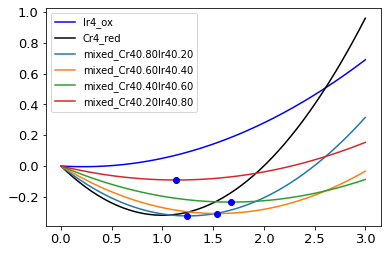

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


X_tots
1.00, 1.25, 1.54, 1.67, 1.14, 0.22, 
Δ Cs
-0.32, -0.32, -0.31, -0.23, -0.09, -0.00, 

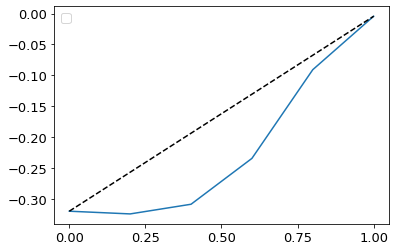

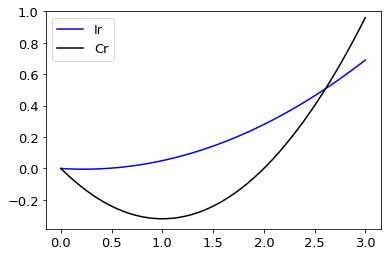

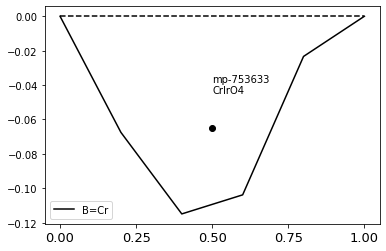

In [18]:
oxidation_state = 4
for housing_element in ['Ir']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

    for ele in ['Cr']:

        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, plotting=True)

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
            #print(pred_1)
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
            #print(pred_2)
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])

                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
                        
    plt.xticks([0, 0.25, 0.5, 0.75, 1], fontsize=13)
    plt.legend()
    #plt.xlabel("$x, {}_{{1-z}}Cr_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    #plt.savefig("Cr_Mo_1d.pdf")
        

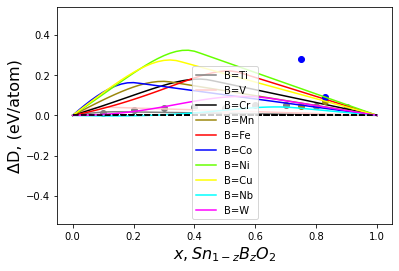

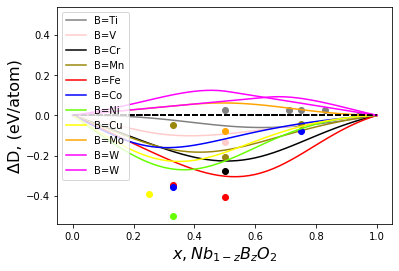

In [7]:
oxidation_state = 4
for housing_element in ['Sn', 'Nb']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = np.linspace(0, 1.00, 51)

    for ele in d2metals['3']+d2metals['4']+d2metals['5']:
        #print(ele)
        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])

        
    plt.legend()
    plt.xlabel("$x, {}_{{1-z}}B_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.ylabel("ΔD, (eV/atom)", fontsize=16)
    plt.ylim(-0.54, 0.54)
    plt.show()
        
        

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 394
MAE for unfiltered: 0.104
total matches with good geom: 232
MAE for filtered: 0.091


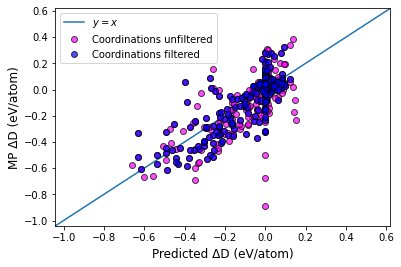

In [14]:
ox2oxide_type = {
    "4": "$A_{1-z}B_{z}O_{2}$"
}
maes = []
num_oxides = []

good_maes = []
num_good_oxides = []
# dictionary mapping oxidation state to x/y plot for oxides conditioned on geometry
ox2good_xs = defaultdict()
ox2good_ys = defaultdict()

# dictionary mapping oxidation state to form ene x/y plot for all oxides 
ox2pred_form_enes = defaultdict()
ox2mp_form_enes = defaultdict()
ox2weighted_avgs = defaultdict()
# dictionary mapping oxidation state to form ene x/y plot for oxides conditioned on geometry
ox2good_mp_form_enes = defaultdict()
ox2good_weighted_avgs = defaultdict()


for oxidation_state in [4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []
    lower_lim = -2.15
    upper_lim = 1.1
    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                #closest_idx = find_nearest(zs, conc)
                if ele+"_{:.2f}".format(conc)==ele_conc:# in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    # the ele conc is the one we get a ΔD value for at 
                    # given conc, and this has to match the way
                    # the weighted average was calculated
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                    closest_idx = find_nearest(zs, conc)

                elif housing_element+"_{:.2f}".format(conc)==ele_conc:
                    # the 'housing_element' is the one with that conc
                    inner_key = housing_element+ele+"{:.2f}".format(conc)
                    # since the ΔD is calculated for ele conc, need to switch 
                    # to the other side of the diagram
                    closest_idx = find_nearest(zs, 1-conc)
                    
                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[ele_conc]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[ele_conc]['MP weighted average'],
                    "true formation energy": info_dict[ele_conc]['MP weighted average']+info_dict[ele_conc]['MP ΔD'],
                    "weighted average of refs": info_dict[ele_conc]['MP weighted average'],
                    "coordination_match": info_dict[ele_conc]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[ele_conc]['MP_id'],
                    "mp_name": info_dict[ele_conc]['MP_name'],
                    "motifs": info_dict[ele_conc]['motifs'],
                }
                
    plt.plot([lower_lim, upper_lim], [lower_lim, upper_lim], label='$y=x$')
    xs = []
    ys = []
    pred_form_enes = []
    mp_form_enes = []
    weighted_avgs = []
    for key, val in data_dict.items():
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        
        pred_form_enes.append(val['predicted formation energy'])
        mp_form_enes.append(val['true formation energy'])
        weighted_avgs.append(val['weighted average of refs'])
    print("total matches: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='fuchsia', alpha=0.7, label='Coordinations unfiltered', markeredgecolor='k')
    print("MAE for unfiltered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_oxides.append(len(xs))
    ox2pred_form_enes[oxidation_state] = pred_form_enes
    ox2mp_form_enes[oxidation_state] = mp_form_enes
    ox2weighted_avgs[oxidation_state] = weighted_avgs

    xs = []
    ys = []
    pred_form_enes = []
    mp_form_enes = []
    weighted_avgs = []
    for key, val in data_dict.items():
        if not val['coordination_match']:
            # bad geometry, skip
            continue
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        
        pred_form_enes.append(val['predicted formation energy'])
        mp_form_enes.append(val['true formation energy'])
        weighted_avgs.append(val['weighted average of refs'])

    print("total matches with good geom: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='b', alpha=0.7, label='Coordinations filtered', markeredgecolor='k')
    print("MAE for filtered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlim(-1.04, 0.62)
    plt.ylim(-1.04, 0.62)
    plt.legend()
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    plt.show()
    good_maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_good_oxides.append(len(xs))
